In [ ]:
import numpy as np # primary math library
import matplotlib.pyplot as plt # primary plotting library
%matplotlib inline

import nelpy as nel # should be installed using pip install nelpy

import warnings
#warnings.filterwarnings("ignore") # useful to prevent excess nelpy warnings

In [2]:
# dataroot = '/Users/ckemere/Development/Data/Frank/';
dataroot = '/home/kemerelab/Data/'

In [3]:
import os

filename = os.path.join(dataroot,'FullMVDMData.nel')
import nelpy.io
jar = nel.load_pkl(filename)

data = jar.Data
del jar


In [4]:
data.keys()

dict_keys(['R042', 'R044', 'R050', 'R064'])

# Calculate tuning curves for all neurons for all animals and days

In [6]:
from numpy import unravel_index
    
sigma_500ms = 0.5 # Smoothing for speed calculation
# Bin sizes are 500 ms, and then we slide
ds_run = 0.250 # 250 ms
ds_50ms = 0.05

sigma_250ms = 0.25 # 250 ms spike smoothing

min_duration = 1 # require that estimation periods be at least 1 second long

# Smoothing standard deviation
sigma_tc = 2.5 # tuning curve smoothing std in cm
min_spikes = 5

PFCenters = {}
TuningCurves = {}

for anim, animdata in data.items():
    if anim != 'R042':
        continue;
    PFCenters[anim] = {}
    TuningCurves[anim] = {}
    
    for day, daydata in animdata.items():
        print(anim, day)
        S = daydata['spikes']
        pos = daydata['pos']

        # Bins for tuning curves
        if (anim == 'R042'):
            x_extents = [25,225] # Read these off of maze figure above
            y_extents = [0,210]
        
        nx = np.diff(x_extents)/5 # plan for 5 cm bins
        ny = np.diff(y_extents)/5

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            speed = nel.utils.dxdt_AnalogSignalArray(pos, smooth=True, sigma=sigma_500ms)

        # get_run_epochs is a utility function which wraps a speed threshold. This finds periods where the speed
        #   is greater than v2 and reaches at least a maximum of v1.
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice
            run_epochs = pos.support.intersect(run_epochs)  
            run_epochs = run_epochs.intersect(daydata['trial_iv'])

        st_run = S[run_epochs]

        # bin, smooth and re-bin:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma_250ms, inplace=True).rebin(w=ds_run/ds_50ms)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tc = nel.TuningCurve2D(bst=bst_run, extern=pos, 
                                   ext_xmin=x_extents[0], ext_xmax=x_extents[1], 
                                   ext_ymin=y_extents[0], ext_ymax=y_extents[1],
                                   ext_nx=nx, ext_ny=ny,
                                   sigma=sigma_tc, min_duration=1)

        TuningCurves[anim][day] = tc
        PFCenters[anim][day] = []

        for idx, pf in enumerate(tc.ratemap):
            placefield = pf.T
            peak = unravel_index(placefield.squeeze().argmax(),placefield.shape)
            PFCenters[anim][day].append([idx, placefield.max(), peak[0], peak[1]])

    


R042 2013-08-16
R042 2013-08-17
R042 2013-08-18
R042 2013-08-19
R042 2013-08-20
R042 2013-08-21


# Plot an example tuning curve

In [8]:
anim = 'R042'
day = '2013-08-20'

/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


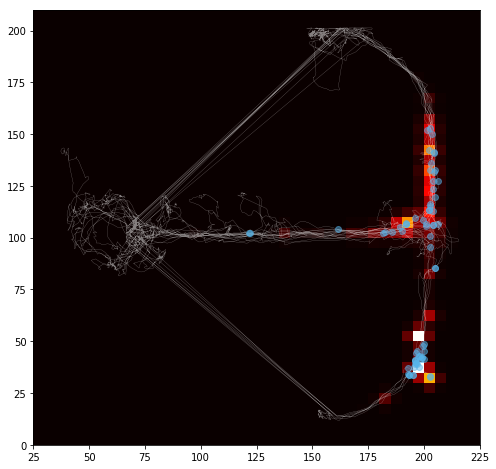

In [12]:
import nelpy.plotting as npl

tc = TuningCurves[anim][day]
xx_mid = tc.xbin_centers
yy_mid = tc.ybin_centers

S = data[anim][day]['spikes']
pos = data[anim][day]['pos']

runpos = pos[data[anim][day]['trial_iv'],:]

fig, ax = plt.subplots(1,1, figsize = (8, 8))

xvals, yvals = runpos.simplify(n_points=5000).asarray().yvals

nidx = 2
xspks, yspks = runpos.asarray(at=S[runpos.support].time[nidx]).yvals

ax.set_aspect('equal')
placefield = tc.ratemap[nidx]
npl.imagesc(x=xx_mid, y=yy_mid, data=placefield.T, cmap=plt.cm.hot, ax=ax)
ax.plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
ax.plot(xspks, yspks, 'o', color=npl.colors.sweet.blue, alpha=0.5)



# Decode each ripple's total position and odds over maze zones

In [13]:
def calculate_shuffle_odds(swr, ratemap, left_pixels, right_pixels, n_shuffles=500):
    if swr.n_active == 0:
        return (np.nan, 0)

    NN = ratemap.shape[0]
    bayes_estimate = -ratemap.sum(axis=0).T + np.log(ratemap.T).dot(swr.n_spikes)
    left_odds = (bayes_estimate * left_pixels.T).sum()
    right_odds = (bayes_estimate * right_pixels.T).sum()

    true_odds = left_odds - right_odds

    shuf_odds = []
    for n in range(n_shuffles):
        shuf_rate = ratemap.copy()
        shuf_rate = shuf_rate[np.random.permutation(NN),:,:]
        shuf_est = -shuf_rate.sum(axis=0).T + np.log(shuf_rate.T).dot(swr.n_spikes)
        left_odds = (shuf_est * left_pixels.T).sum()
        right_odds = (shuf_est * right_pixels.T).sum()
        shuf_odds.append(left_odds - right_odds)
        
    return (true_odds, shuf_odds)


In [17]:
from joblib import Parallel, delayed
from scipy import stats
import time
from shapely.geometry import box, Point

RippleArmScores = {}

for anim, animdata in data.items():
    RippleArmScores[anim] = {}
    if anim != 'R042':
        continue
    
    for day, daydata in animdata.items():
        print(anim, day)
        t0 = time.time()


        ########################################################
        # Calculate pixel bins for left and right decoding areas
        nx = TuningCurves[anim][day].n_xbins
        ny = TuningCurves[anim][day].n_ybins
        xx_mid = TuningCurves[anim][day].xbin_centers
        yy_mid = TuningCurves[anim][day].ybin_centers
        
        # Find left and right arm PFs using shapely
        if anim=='R042':
            RightArmCoords = [150,0,225,85]
            LeftArmCoords = [150,120,225,220]

        # left_box = box(*data[anim][day]['LeftArmRect'])
        # right_box = box(*data[anim][day]['RightArmRect'])
        left_box = box(*LeftArmCoords)
        right_box = box(*RightArmCoords)
        
        left_pixels = np.zeros((int(nx),int(ny)))
        right_pixels = np.zeros((int(nx),int(ny)))
        for ix, x in enumerate(xx_mid):
            for iy, y in enumerate(yy_mid):
                left_pixels[ix,iy] = left_box.contains(Point([x,y]))
                right_pixels[ix,iy] = right_box.contains(Point([x,y]))
        ########################################################

        t1 = time.time()
        print('Pixel areas decided', t1-t0, 's')

        ratemap = TuningCurves[anim][day].ratemap
        swr_eps = data[anim][day]['event-candidates']
        S = daydata['spikes']        
        pos = daydata['pos']

        if (swr_eps.n_epochs < 20):
            continue
        
        RippleArmScores[anim][day] = {}
        
        RippleArmScores[anim][day]['RippleEpochs'] = swr_eps

        swrtimes = swr_eps.starts
        
        isi = np.insert(np.diff(swrtimes),0,-np.nan)
        RippleArmScores[anim][day]['TimeSinceLastRipple'] = isi

        print('Scoring starting')

        swr_spikes = S[swr_eps]

        results = Parallel(n_jobs=29)(delayed(calculate_shuffle_odds)(swr, 
                                ratemap, left_pixels, right_pixels) for swr in swr_spikes)
        t2 = time.time()
        print('Done in ', t2-t1, 's')

        true_odds, shuf_odds = zip(*results)

        RippleArmScores[anim][day]['TrueOdds'] = true_odds
        RippleArmScores[anim][day]['OddsShuffles'] = shuf_odds

        shuf_ratio = []
        for idx, t in enumerate(true_odds):
            if not np.isnan(t):
                shuf_ratio.append(stats.percentileofscore(shuf_odds[idx],t))
            else:
                shuf_ratio.append(np.nan)
                
        shuf_ratio = np.array(shuf_ratio)
        RippleArmScores[anim][day]['TruePercentiles'] = shuf_ratio
        RippleArmScores[anim][day]['ScoreOfLastRipple'] = np.hstack([np.nan, shuf_ratio[:-1]])

        shuf_ratio2 = np.zeros(shuf_ratio.shape)
        shuf_ratio2[shuf_ratio > 75] = 1.0
        shuf_ratio2[shuf_ratio < 25] = -1.0
        RippleArmScores[anim][day]['TruePercentilesThresholded'] = shuf_ratio2
        RippleArmScores[anim][day]['ScoreOfLastRippleThresholded'] = np.hstack([0, shuf_ratio2[:-1]])
        
        print(len(isi), len(np.hstack([shuf_ratio[1:], np.nan])))
    

R042 2013-08-16
Pixel areas decided 0.05166053771972656 s
Scoring starting
Done in  40.91968560218811 s
1127 1127
R042 2013-08-17
Pixel areas decided 0.047982215881347656 s
Scoring starting
Done in  74.0440125465393 s
595 595
R042 2013-08-18
Pixel areas decided 0.06068897247314453 s
Scoring starting
Done in  226.88741421699524 s
1315 1315
R042 2013-08-19
Pixel areas decided 0.069000244140625 s
Scoring starting
Done in  144.00019526481628 s
1380 1380
R042 2013-08-20
Pixel areas decided 0.04864645004272461 s
Scoring starting
Done in  199.51669931411743 s
1675 1675
R042 2013-08-21
Pixel areas decided 0.04713296890258789 s
Scoring starting
Done in  129.11847019195557 s
1331 1331


# Plot an example event

In [20]:
data[anim].keys()

dict_keys(['2015-04-18', '2015-04-19', '2015-04-20', '2015-04-21', '2015-04-22', '2015-04-23'])

/home/kemerelab/Code/nelpy/nelpy/core/_spiketrain.py:898: UserWarning: ignoring spikes outside of spiketrain support
/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


Text(0.5,1,'Percentile = 90.8')

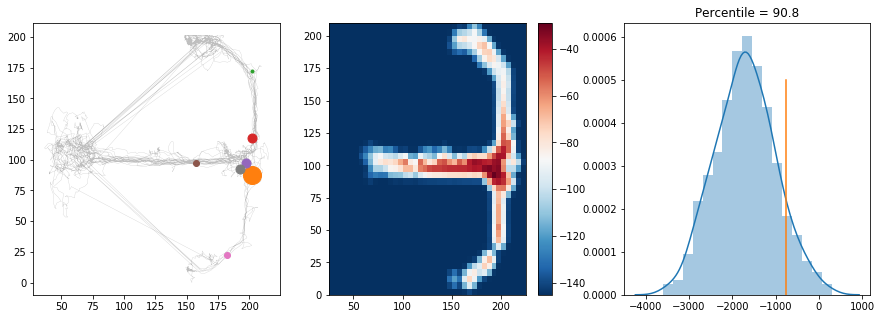

In [72]:
import seaborn as sns

anim = 'R042'
day = '2013-08-16'


swr_eps = data[anim][day]['event-candidates']
S = data[anim][day]['spikes']        
pos = data[anim][day]['pos']

p = np.array(PFCenters[anim][day],dtype=int)
pfcenters = np.vstack((tc.xbin_centers[p[:,3]], tc.ybin_centers[p[:,2]])).T


swr_spikes = S[swr_eps]

ratemap = TuningCurves[anim][day].ratemap * 0.1


ex = 7

swr = swr_spikes[ex]

fig, ax = plt.subplots(1,3,figsize=(15,5))


run_epochs = data[anim][day]['trial_iv']
runpos = pos[run_epochs]
xvals, yvals = runpos.simplify(n_points=5000).asarray().yvals
ax[0].plot(xvals, yvals, lw=0.25, color='gray', alpha=0.5)

for nidx, n in enumerate(swr.n_spikes):
    if n > 0:
        ax[0].plot(pfcenters[nidx][0],pfcenters[nidx][1],'o',markersize=3*n);
    


bayes_estimate = -ratemap.sum(axis=0).T + np.log(ratemap.T).dot(swr.n_spikes)
left_odds = (bayes_estimate * left_pixels.T).sum()
right_odds = (bayes_estimate * right_pixels.T).sum()

true_odds = left_odds - right_odds

ax[1].set_aspect('equal')
ax[1], img = npl.imagesc(x=xx_mid, y=yy_mid, data=bayes_estimate, cmap=plt.cm.RdBu_r, ax=ax[1])
plt.colorbar(img, ax=ax[1])

sns.distplot(RippleArmScores[anim][day]['OddsShuffles'][ex], ax=ax[2])
ax[2].plot(RippleArmScores[anim][day]['TrueOdds'][ex]*np.ones(2),np.array([0,0.0005]))
ax[2].set_title('Percentile = {}'.format(RippleArmScores[anim][day]['TruePercentiles'][ex]))


In [73]:
ds = 0.01 # 10 millisecond bins should be ok?

RipEventData = {}

for day, daydata in data[anim].items():
    print(anim, day)
    swr_eps = data[anim][day]['event-candidates']
    expanded_support = nel.EpochArray([swr_eps.centers[0]-5,swr_eps.centers[-1]+5])
    swr_events = nel.SpikeTrainArray(swr_eps.centers, support=expanded_support)    
    binned_swr_events = nel.BinnedSpikeTrainArray(swr_events, ds=ds)
    RipEventData[day] = {}
    RipEventData[day]['Scores'] = (RippleArmScores[anim][day]['TruePercentiles'] - 50)/100
    RipEventData[day]['TimeSeriesLength'] = binned_swr_events.data.squeeze().shape[0]
    RipEventData[day]['EventInds'] = np.argwhere(binned_swr_events.data.squeeze()==1)


R042 2013-08-16
R042 2013-08-17


/home/kemerelab/Code/nelpy/nelpy/core/_spiketrain.py:532: UserWarning: No sampling rate was specified! Assuming default of 30000 Hz.
/home/kemerelab/Code/nelpy/nelpy/core/_spiketrain.py:532: UserWarning: No sampling rate was specified! Assuming default of 30000 Hz.


R042 2013-08-18
R042 2013-08-19


/home/kemerelab/Code/nelpy/nelpy/core/_spiketrain.py:532: UserWarning: No sampling rate was specified! Assuming default of 30000 Hz.
/home/kemerelab/Code/nelpy/nelpy/core/_spiketrain.py:532: UserWarning: No sampling rate was specified! Assuming default of 30000 Hz.


R042 2013-08-20
R042 2013-08-21


/home/kemerelab/Code/nelpy/nelpy/core/_spiketrain.py:532: UserWarning: No sampling rate was specified! Assuming default of 30000 Hz.
/home/kemerelab/Code/nelpy/nelpy/core/_spiketrain.py:532: UserWarning: No sampling rate was specified! Assuming default of 30000 Hz.


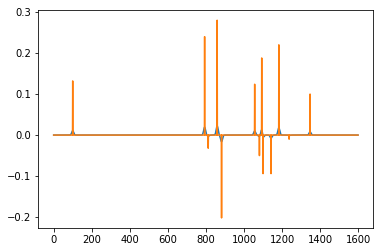

In [61]:
plt.plot(smoothed_scoreTS[400:2000])
plt.plot(score_time_series[400:2000])

# Generate shuffled event autocorrelations

In [62]:
def autocorrelate(x, NA=10000):
    autocor = np.zeros(NA)
    for lag in range(NA):
        if lag == 0:
            autocor[lag] = np.inner(x, x)/len(x)
        else:
            autocor[lag] = np.inner(x[:-lag], x[lag:]) / len(x[lag:])
            
    return autocor

In [65]:
NA = 10000

score_time_series = np.zeros(RipEventData[day]['TimeSeriesLength'])
score_time_series[RipEventData[day]['EventInds']] = np.expand_dims(RipEventData[day]['Scores'],1)
smoothed_scoreTS = scipy.ndimage.filters.gaussian_filter1d(score_time_series,sigma=sigma)

autocor = autocorrelate(smoothed_scoreTS.squeeze(),NA=NA)

In [80]:
def shuffle_autocorrelation(event_indices, event_values, nbins, sigma):
    shuf_time_series = np.zeros(nbins)
    shuf_time_series[event_indices] = np.random.permutation(event_values)
    smoothed_shuf = scipy.ndimage.filters.gaussian_filter1d(shuf_time_series,sigma=sigma)
    return autocorrelate(smoothed_shuf.T)
    

In [ ]:
plt.semilogx(np.arange(NA-1)*ds, autocor[1:]*(1/ds)*(1/ds))
plt.gca().set_ylim(-0.005,0.005)


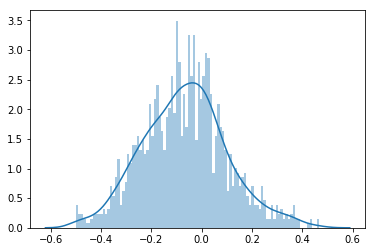

In [71]:
sns.distplot((RippleArmScores[anim][day]['TruePercentiles'] - 50)/100,100)

In [74]:
raw_autocor = autocorrelate( (RippleArmScores[anim][day]['TruePercentiles']-50)/100 )

/home/kemerelab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars


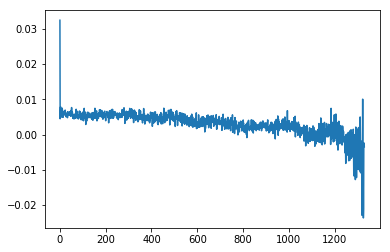

In [76]:
plt.plot(raw_autocor)

In [77]:
NShufRaw = 500
true_scores = (RippleArmScores[anim][day]['TruePercentiles']-50)/100
RawShuf = np.zeros((raw_autocor.shape[0],NShufRaw))
for i in range(NShufRaw):
    RawShuf[:,i] = autocorrelate(np.random.permutation(true_scores))
    

/home/kemerelab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars


/home/kemerelab/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile


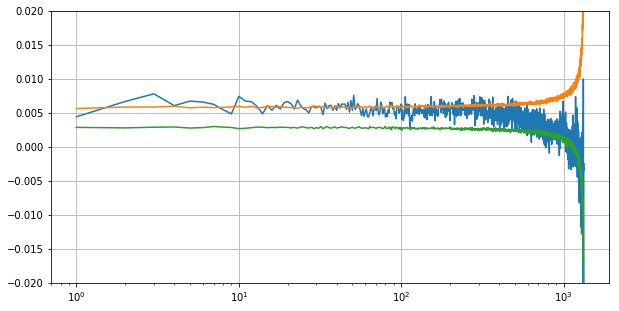

In [78]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.semilogx(raw_autocor)
ax.semilogx(np.percentile(RawShuf,97.5,axis=1))
ax.semilogx(np.percentile(RawShuf,2.5,axis=1))
ax.set_ylim(-0.02,0.02)
ax.grid(True)

In [79]:
NShufs = 250
shuf_autocor2 = np.zeros((NA,NShufs))
true_scores = (RippleArmScores[anim][day]['TruePercentiles'] - 50)/100

event_indices = np.argwhere(binned_swr_events.data[0,:]==1).squeeze()

import time

t1 = time.time()
for i in range(NShufs):
    if (i % 25 == 0):
        print(i)
    shuf_autocor2[:,i] = shuffle_autocorrelation(event_indices, true_scores, score_time_series.shape[1], sigma)
t2 = time.time()

print('Parallel time: {}. Single thread time: {}'.format(t1-t0,t2-t1))
    

0


IndexError: tuple index out of range

In [ ]:
shuf_autocor2.shape

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.semilogx(np.arange(NA)*ds, autocor*(1/ds)*(1/ds))
ax.semilogx(np.arange(NA)*ds, np.percentile((shuf_autocor2),95,axis=1)*(1/ds)*(1/ds))
ax.semilogx(np.arange(NA)*ds, np.percentile((shuf_autocor2),5,axis=1)*(1/ds)*(1/ds))

ax.set_ylim(-0.01,0.01)


In [ ]:
swr_eps.n_epochs

In [ ]:
print(left_odds, right_odds)

print(RippleArmScores[anim][day]['TrueOdds'][ex])

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sr = np.array(shuf_ratio)
sns.distplot(sr[~np.isnan(sr)],50, ax=ax[0])

sr = np.array(shuf_ratio2)
sns.distplot(sr[~np.isnan(sr)],50, ax=ax[1])

In [ ]:
all_score_diffs = []
all_score_diffs_shuff = []
all_last_times = []
NShuf = 500

for anim, ripscores in RippleArmScores.items():
    shuf_ratios = []
    last_ratios = []
    last_times = []
    score_diffs = []
    shuff_score_diffs = []
    for day, datum in ripscores.items():
        sc = np.array(datum['TruePercentilesThresholded'])
        if (len(sc[~np.isnan(sc)]) == 0):
            continue
            
        shuf_ratios.append(sc)
        lastsc = np.array(datum['ScoreOfLastRippleThresholded'])
        last_ratios.append(lastsc)
        lastT = np.array(datum['TimeSinceLastRipple'])
        last_times.append(lastT)
        # score_diffs.append(np.abs(sc - lastsc))
        score_diffs.append(sc*lastsc)
        
        # now we want to generate shuffle distribution of score_diffs
        shuffs = np.zeros((len(sc),NShuf))
        for idx in range(NShuf):
            # shuffs[:,idx] = np.abs(np.random.permutation(sc) - lastsc)
            shuffs[:,idx] = np.random.permutation(sc)*lastsc
        shuff_score_diffs.append(shuffs)
        
        print(day, sc.shape, lastT.shape, lastsc.shape, shuffs.shape)


    all_shuf_ratios = np.hstack(shuf_ratios)
    all_score_diffs.append(np.hstack(score_diffs))
    all_score_diffs_shuff.append(np.vstack(shuff_score_diffs))
    all_last_times.append(np.hstack(last_times))


In [ ]:
sc = score_diffs[0]
sns.distplot(sc[~np.isnan(sc)], kde=False)

In [ ]:
lastT.shape

In [ ]:
print(np.mean(score_diffs[0] == 1))
print(np.mean(np.hstack(shuff_score_diffs[0]) == 1))

In [ ]:

bins = np.linspace(-5,5,11)
# actual_diff = sc - lastsc
# actual_diff2 = actual_diff[~np.isnan(actual_diff)]
actual_diff = sc*lastsc

lastT[0] = 10

good = ~np.isnan(actual_diff)
hactual, _ = np.histogram(actual_diff[good], bins=bins)
true_vals, tbins , _ = stats.binned_statistic(np.log10(lastT[good]), actual_diff[good], 'mean', bins=20)

shuf_scores = []
sh_val_list = []
for idx in range(NShuf):
    # shsc = np.abs(np.random.permutation(sc) - lastsc)
    # shsc = np.random.permutation(sc) - lastsc
    shsc = np.random.permutation(sc)*lastsc
    shuf_scores.append(shsc)

    good = ~np.isnan(shsc)

    sh_vals, _, _ = stats.binned_statistic(np.log10(lastT[good]), shsc[good], 'mean', bins=tbins)
    sh_val_list.append(sh_vals)

    



In [ ]:
actual_diff.shape

In [ ]:
plt.plot(tbins[:-1], np.vstack(sh_val_list).T, lw=0.25);
plt.plot(tbins[:-1], true_vals, lw=3)
